In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient
import pymongo
import configparser
# from utils_parameter_search.utils_parameter_search import visualize_accuracy_vs_hyperparameter
import math
import seaborn as sns
import numpy as np
%matplotlib inline 

In [2]:
def visualize_accuracy_vs_hyperparameter(
    df, hyperparameters, accuracy_field="accuracy", acc_threshold=0, fig_types = None
):
    figure, axes = plt.subplots(
        math.ceil(len(hyperparameters) / 2),
        2,
        figsize=(15, 8),
        constrained_layout=True,
    )
    axes = np.reshape(axes, (-1))

    if fig_types is None:
        fig_types = ["scatterplot" for _ in range(len(hyperparameters))]

    for ax, column, fig_type in zip(axes, hyperparameters, fig_types):
        if fig_type == "boxplot":
            sns.boxplot(df, x=column, y=accuracy_field, ax=ax)
        else:
            sns.scatterplot(df, x=column, y=accuracy_field, ax=ax)
        plt.xticks(rotation=90)
    plt.tight_layout()
    # return figure

In [3]:
def read_config() -> configparser.ConfigParser:
    config = configparser.ConfigParser()
    config.read("../configuracion.ini")
    return config


def get_collection(config) -> pymongo.collection.Collection:
    client = MongoClient(config["MONGODB"]["connection"])
    db = client[config["MONGODB"]["database"]]
    collection = db[config["MONGODB"]["collection"]]

    return collection

In [4]:
config = read_config()
collection = get_collection(config)

# Logistic Regression

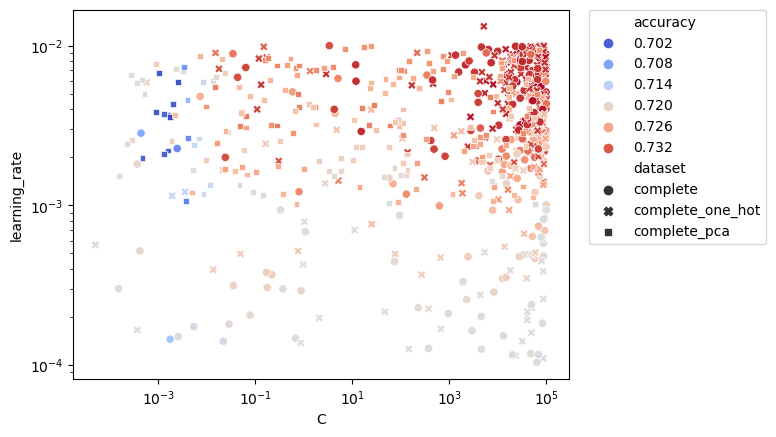

In [26]:
logistic_regression = collection.find({"model": "logistic_regression"})
log_regression_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_of_fit"]} for doc in logistic_regression])

log_regression_df.sort_values("accuracy", ascending=False)
acc_threshold = 0.7
sns.scatterplot(log_regression_df[log_regression_df["accuracy"] > acc_threshold], x = "C", y = "learning_rate", hue = "accuracy", style = "dataset", palette="coolwarm")
plt.xscale("log")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.04 , 1), borderaxespad=0)


C:\Users\jurko\AppData\Local\Temp\ipykernel_26528\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


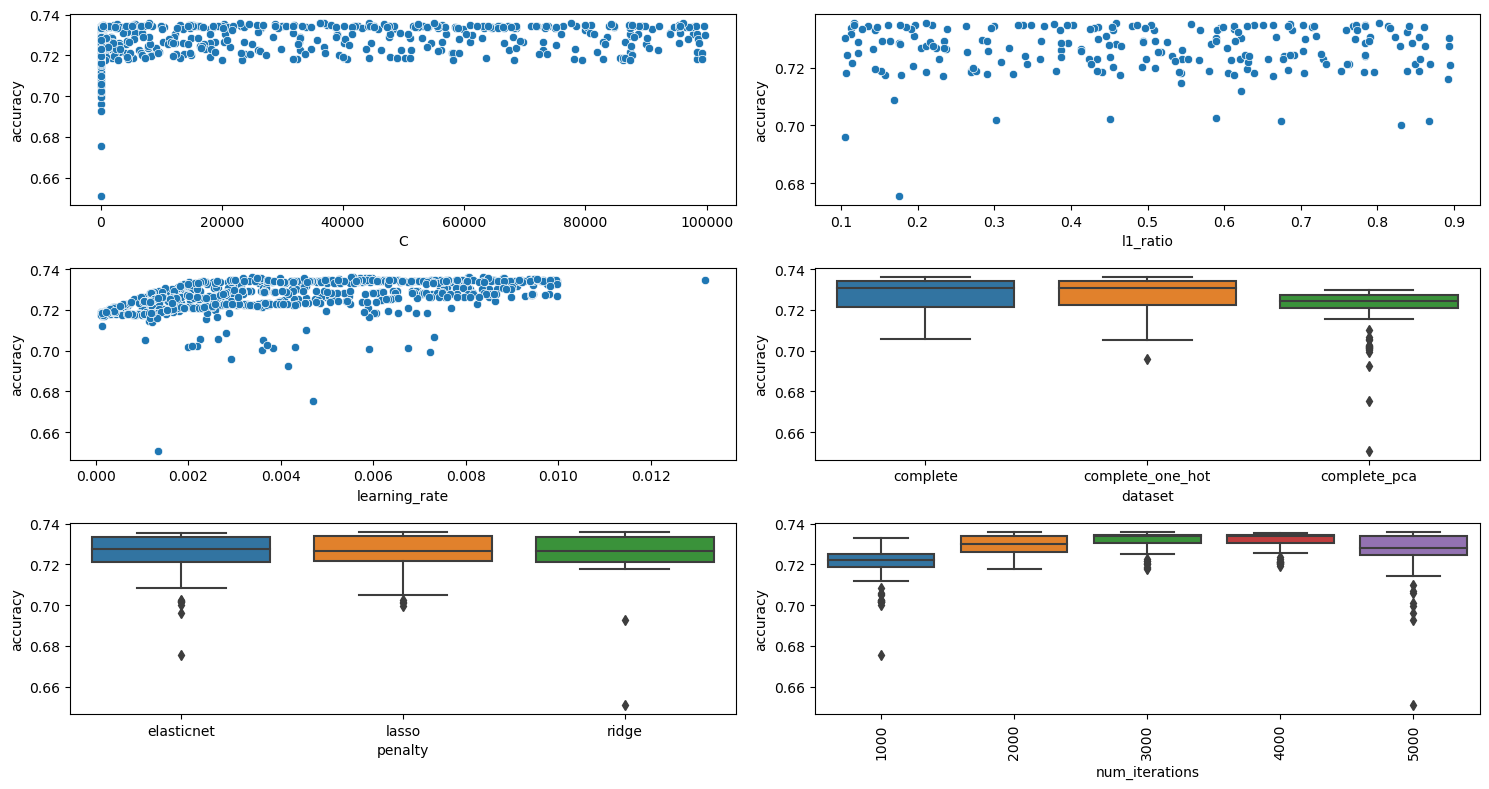

In [27]:
acc_threshold = 0.65
visualize_accuracy_vs_hyperparameter(log_regression_df[log_regression_df["accuracy"] > acc_threshold], ["C", "l1_ratio", "learning_rate", "dataset", "penalty", "num_iterations"], fig_types=["", "", "", "boxplot", "boxplot", "boxplot"])
# sns.boxplot(log_regression_df[log_regression_df["accuracy"] > acc_threshold], x = "dataset", y="accuracy")

# KNN

In [28]:
knn = collection.find({"model": "knn"})
knn_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_of_fit"]} for doc in knn])

In [29]:
knn_df

,accuracy,dataset,k,p
0,0.727379,complete_one_hot,114,1
1,0.722326,complete_one_hot,117,3
2,0.718959,complete,115,4
3,0.727614,complete,132,1
4,0.721376,complete_one_hot,44,1
...,...,...,...,...
551,0.725696,complete_pca,77,2
552,0.719197,complete_pca,61,1
553,0.722801,complete_pca,94,1
554,0.725937,complete_pca,75,2


Text(0.5, 1.0, 'Hyperparameter search KNN')

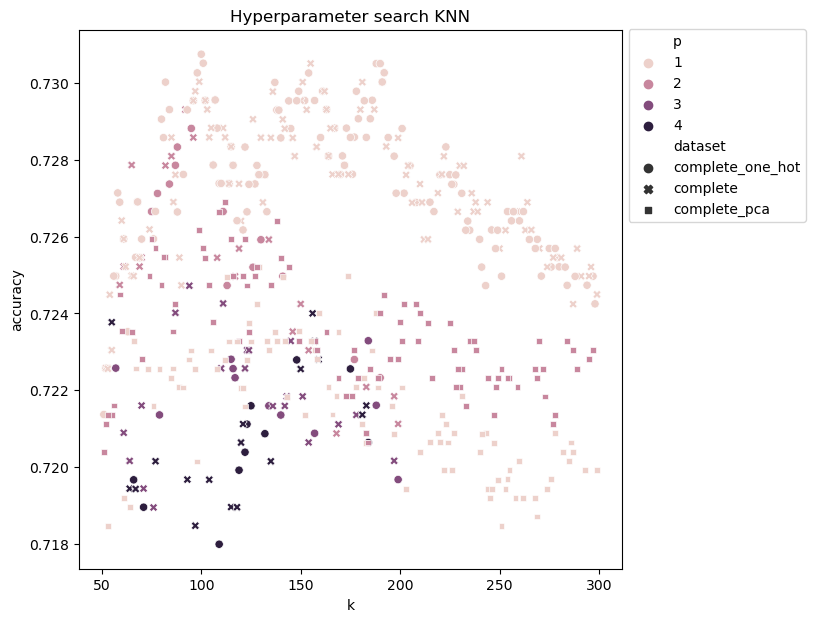

In [33]:
plt.figure(figsize=(7,7))
knn_df["accuracy_73"] = (knn_df["accuracy"] >= 0.7)*1+ (knn_df["accuracy"] >= 0.73)*1
sns.scatterplot(knn_df[knn_df["k"] > 50], x = "k", y = "accuracy", hue = "p", style = "dataset")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.822))
plt.title("Hyperparameter search KNN")
# plt.legend()
# plt.xscale("log")
# plt.yscale("log")

Text(0.5, 1.0, 'Accuracy for each dataset used with KNN')

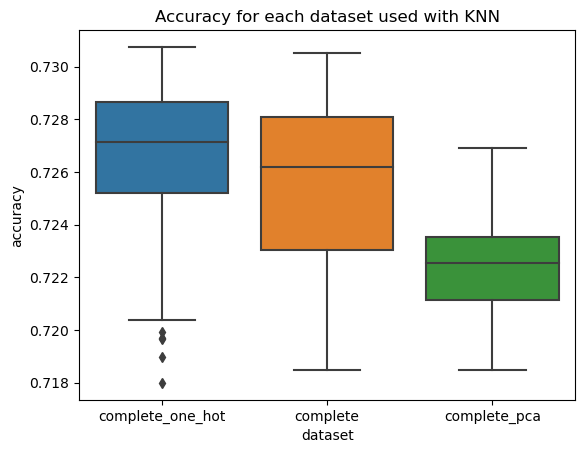

In [35]:
acc_threshold = 0.65
sns.boxplot(knn_df[(knn_df["accuracy"] > acc_threshold) & (knn_df["k"] > 50)], x = "dataset", y="accuracy")
plt.title("Accuracy for each dataset used with KNN")

# SVM

In [111]:
svm = collection.find({"model": "svm"})
svm_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc.get("params_of_fit", {}), **doc.get("params_initialization", {})} for doc in svm])

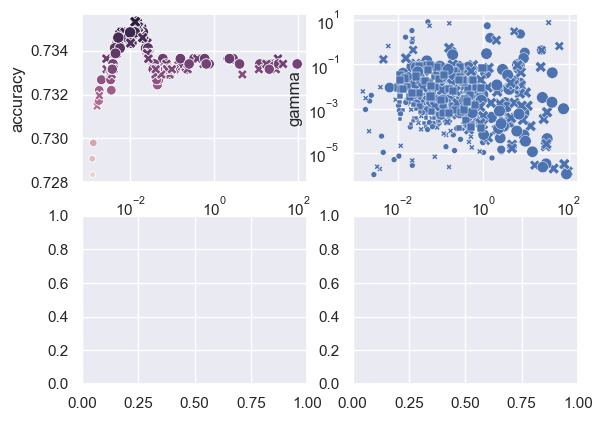

In [112]:
fig, axes = plt.subplots(2, 2)
axes = axes.reshape((-1))
for i, kernel in enumerate(["linear", "rbf"]):
    kernel_df = svm_df[svm_df["kernel"] == kernel]
    if kernel == "poly":
        sns.scatterplot(kernel_df, x = "C", y = "gamma", size = "accuracy", style = "dataset", hue = "degree", ax = axes[i], legend = False)
        axes[i].set_xscale("log")
        axes[i].set_yscale("log")
    elif kernel == "rbf":
        sns.scatterplot(kernel_df, x = "C", y = "gamma", size = "accuracy", style = "dataset", ax = axes[i], legend = False)
        axes[i].set_xscale("log")
        axes[i].set_yscale("log")
        
    else:
        sns.scatterplot(kernel_df, x = "C", y = "accuracy", size = "accuracy", style = "dataset", hue = "accuracy", ax = axes[i], legend = False)
        axes[i].set_xscale("log")
        

# SVM

In [16]:
svm = collection.find({"model_type": "svm"})
svm_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"]} for doc in svm])

In [17]:
svm_df

,accuracy,dataset,kernel,C,gamma,cache_size
0,0.680505,complete,rbf,1.465613,1.540550,7000
1,0.734842,complete,linear,0.007447,NaN,7000
2,0.515616,complete,rbf,0.022075,0.000003,7000
3,0.733152,complete_one_hot,rbf,0.026764,0.104672,7000
4,0.730743,complete_one_hot,rbf,6.793068,0.008334,7000
...,...,...,...,...,...,...
661,0.651785,complete,poly,0.003211,NaN,7000
662,0.704729,complete,poly,0.019823,NaN,7000
663,0.673675,complete,poly,0.005156,NaN,7000
664,0.669104,complete,poly,0.004386,NaN,7000


In [6]:
linear_svm = svm_df[(svm_df["kernel"] == "linear")][["C", "accuracy", "dataset"]]

### Linear

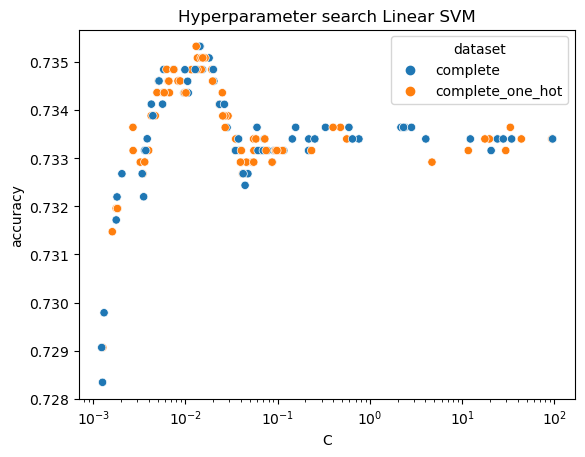

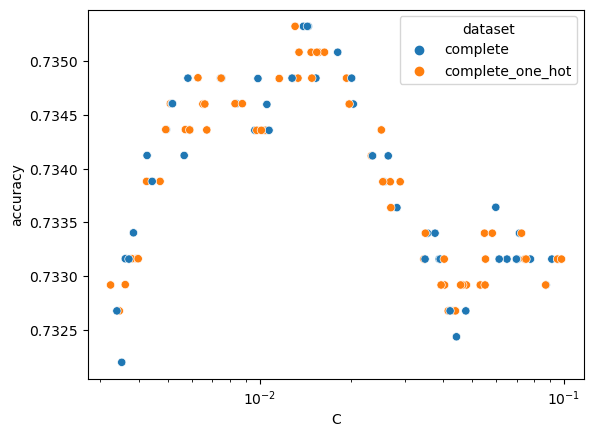

In [25]:
acc_threshold = 0.70
sns.scatterplot(linear_svm[linear_svm["accuracy"] > acc_threshold], x = "C", y = "accuracy", hue = "dataset")
plt.xscale('log')
plt.title("Hyperparameter search Linear SVM")
plt.show()
sns.scatterplot(linear_svm[(linear_svm["accuracy"] > acc_threshold)&(linear_svm["C"]>10**-2.5)&(linear_svm["C"]<10**-1)], x = "C", y = "accuracy", hue = "dataset")
plt.xscale('log')
plt.show()

<Axes: xlabel='dataset', ylabel='accuracy'>

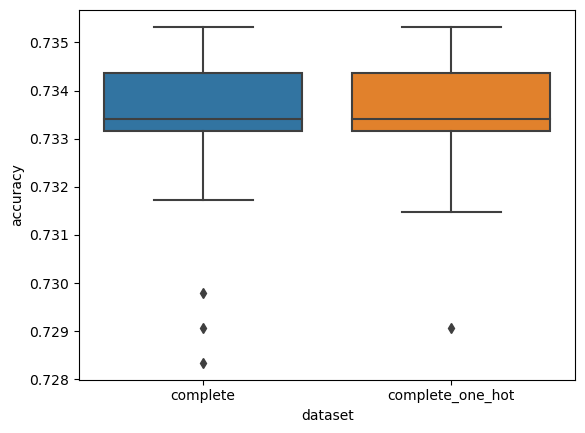

In [8]:
acc_threshold = 0.65
sns.boxplot(linear_svm[(linear_svm["accuracy"] > acc_threshold)], x = "dataset", y="accuracy")

### RBF

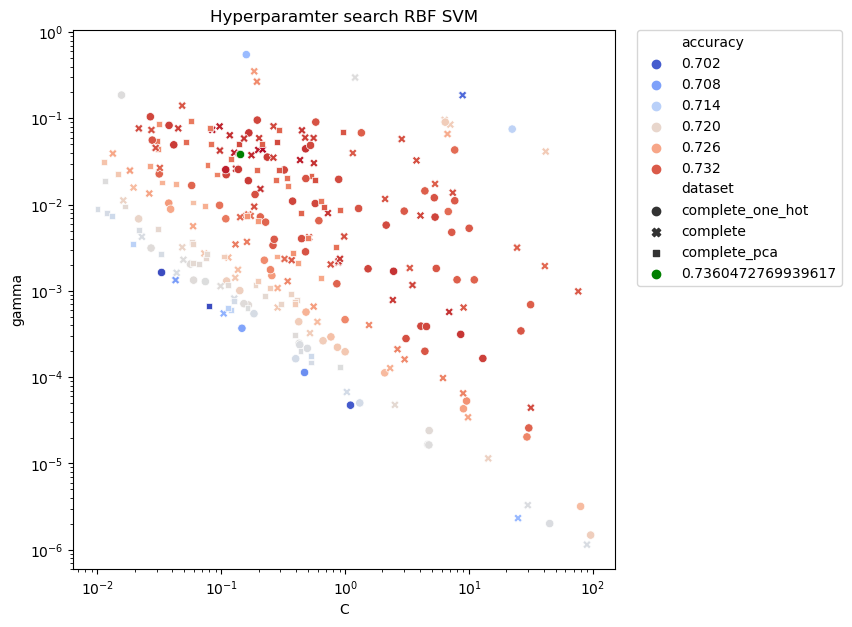

In [26]:
rbf_svm = svm_df[(svm_df["kernel"] == "rbf")&(svm_df["accuracy"] > acc_threshold)][["C", "gamma", "accuracy", "dataset"]]
plt.figure(figsize = (7,7))
sns.scatterplot(rbf_svm[rbf_svm["accuracy"] > 0], x = "C", y = "gamma", hue = "accuracy", style = "dataset" , palette="coolwarm")
sns.scatterplot(rbf_svm[rbf_svm["accuracy"] == rbf_svm["accuracy"].max()], x = "C", y = "gamma", hue= "accuracy", palette = ["green"])
plt.xscale('log')
plt.yscale('log')
plt.title("Hyperparamter search RBF SVM")
plt.legend(bbox_to_anchor=(1.04 , 1), borderaxespad=0)

<Axes: xlabel='dataset', ylabel='accuracy'>

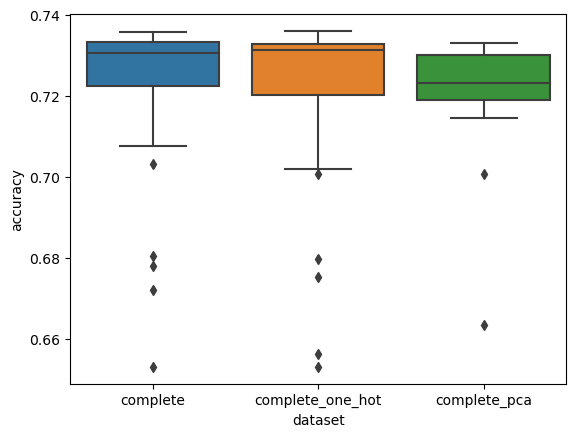

In [10]:
acc_threshold = 0.65
sns.boxplot(rbf_svm[(rbf_svm["accuracy"] > acc_threshold)], x = "dataset", y="accuracy")

### Poly

In [14]:
poly_svm

,C,gamma,accuracy,dataset
566,0.016323,NaN,0.703283,complete
567,0.025541,NaN,0.703283,complete
568,0.026550,NaN,0.702560,complete
569,0.005361,NaN,0.674157,complete
570,0.011687,NaN,0.692939,complete
...,...,...,...,...
661,0.003211,NaN,0.651785,complete
662,0.019823,NaN,0.704729,complete
663,0.005156,NaN,0.673675,complete
664,0.004386,NaN,0.669104,complete


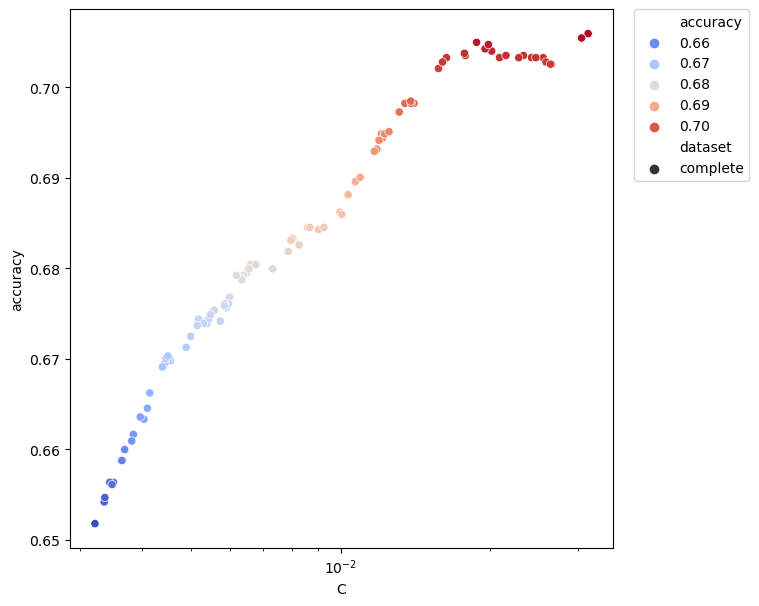

In [20]:
poly_svm = svm_df[(svm_df["kernel"] == "poly")&(svm_df["accuracy"] > acc_threshold)][["C", "gamma", "accuracy", "dataset"]]
plt.figure(figsize = (7,7))
sns.scatterplot(poly_svm[poly_svm["accuracy"] > 0], x = "C", y = "accuracy", hue = "accuracy", style = "dataset" , palette="coolwarm")
# sns.scatterplot(poly_svm[poly_svm["accuracy"] == poly_svm["accuracy"].max()], x = "C", y = "gamma", hue= "accuracy", palette = ["green"])
plt.xscale('log')
# plt.yscale('log')
plt.legend(bbox_to_anchor=(1.04 , 1), borderaxespad=0)

# Trees

In [38]:
tree = collection.find({"model": "tree"})
tree_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"]} for doc in tree])

C:\Users\jurko\AppData\Local\Temp\ipykernel_26528\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


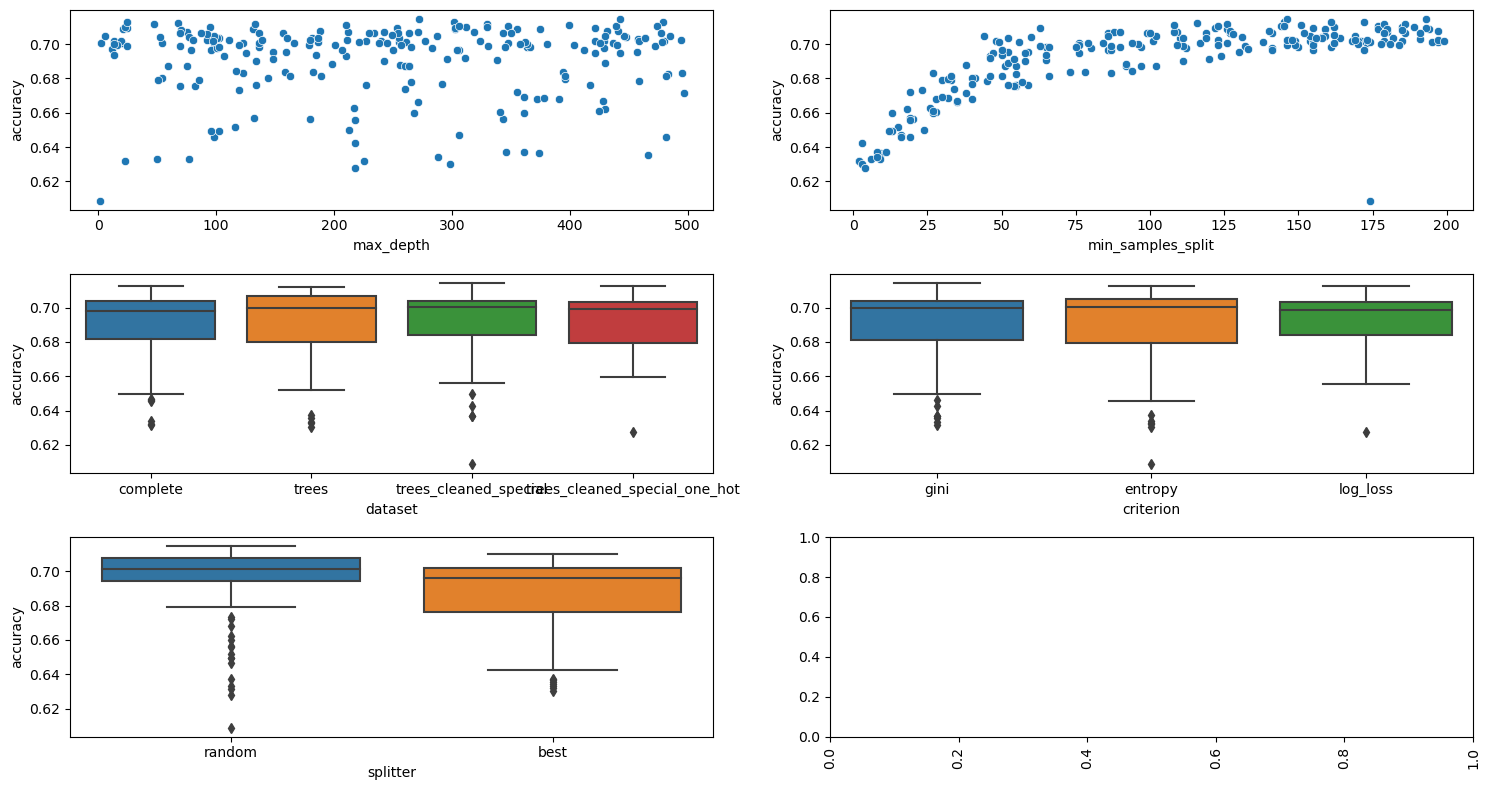

In [39]:
visualize_accuracy_vs_hyperparameter(tree_df, ["max_depth", "min_samples_split", "dataset", "criterion", "splitter"], fig_types=["", "", "boxplot", "boxplot", "boxplot", "boxplot"])

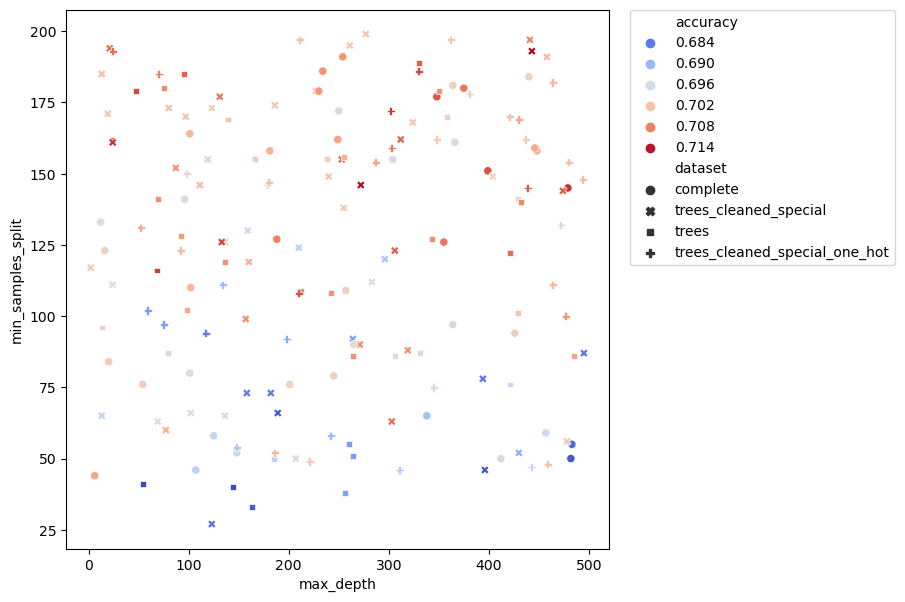

In [40]:
plt.figure(figsize = (7,7))
sns.scatterplot(tree_df[tree_df["accuracy"] > 0.68], x = "max_depth", y = "min_samples_split", hue = "accuracy", style = "dataset" , palette="coolwarm")
plt.legend(bbox_to_anchor=(1.04 , 1), borderaxespad=0)

# Random Forest

C:\Users\jurko\AppData\Local\Temp\ipykernel_26528\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


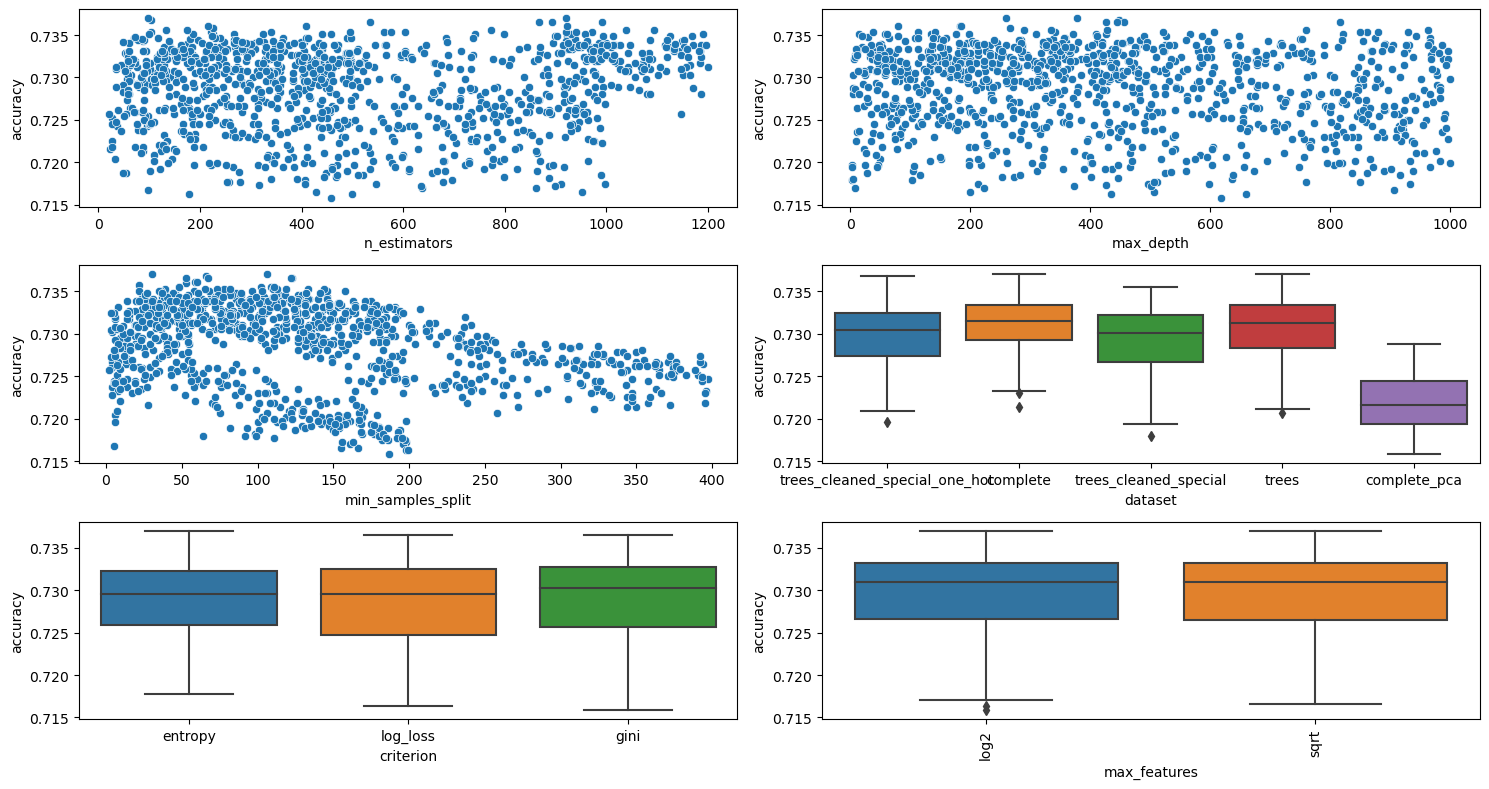

In [41]:
random_forest = collection.find({"model": "random_forest"})
random_forest_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"]} for doc in random_forest])
random_forest_df["n_estimators"]= random_forest_df["n_estimators"].apply(float)
visualize_accuracy_vs_hyperparameter(random_forest_df, ["n_estimators", "max_depth", "min_samples_split", "dataset", "criterion", "max_features"], fig_types=["", "", "", "boxplot", "boxplot", "boxplot", "boxplot"])


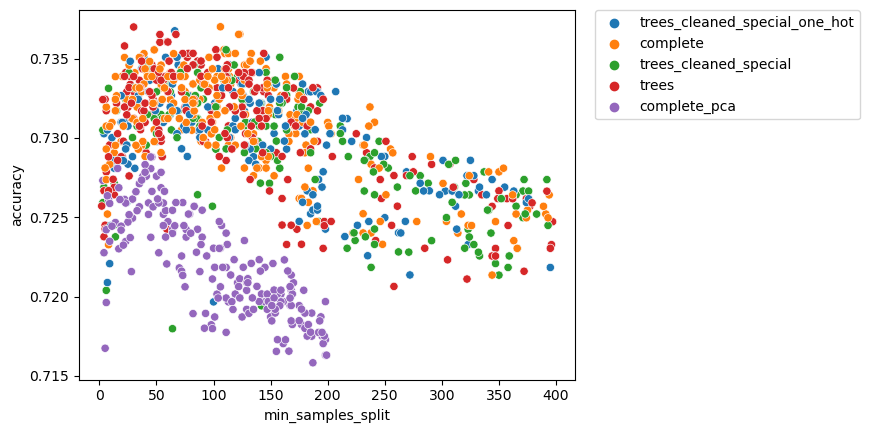

In [42]:
sns.scatterplot(random_forest_df, x = "min_samples_split", y = "accuracy", hue = "dataset")
plt.legend(bbox_to_anchor=(1.04 , 1), borderaxespad=0)

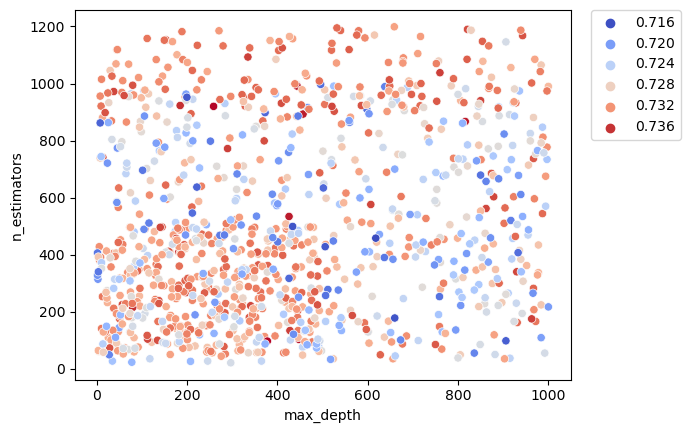

In [43]:
sns.scatterplot(random_forest_df[random_forest_df["accuracy"] > 0.70], x = "max_depth", y = "n_estimators", hue ="accuracy" , palette="coolwarm")
plt.legend(bbox_to_anchor=(1.04 , 1), borderaxespad=0)

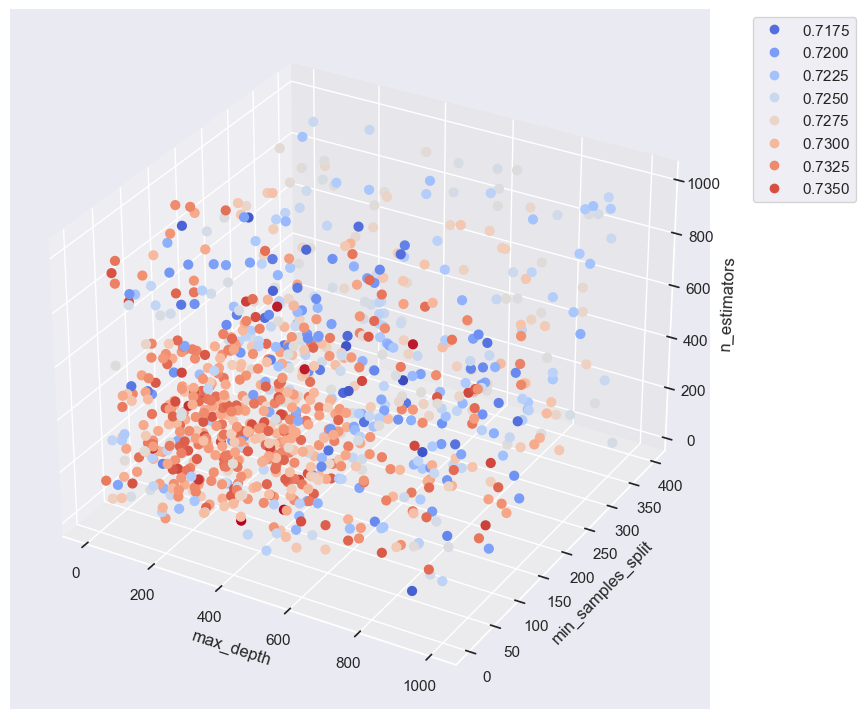

In [124]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


fig = plt.figure(figsize = (7,7))
sns.set(style = "darkgrid")
# ax = fig.add_subplot(111, projection = '3d')
x_label = "max_depth"
y_label = "min_samples_split"
z_label = "n_estimators"
x = random_forest_df[x_label]
y = random_forest_df[y_label]
z = random_forest_df[z_label]

c = random_forest_df["accuracy"]

# ax.scatter(x, y, z)

ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("coolwarm", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=c, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_zlabel(z_label)
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
# plt.savefig("scatter_hue", bbox_inches='tight')

plt.show()

# sns.scatterplot(random_forest_df[random_forest_df["accuracy"] > 0], x = "max_depth", y = "min_samples_split", z="n_estimators", hue = "accuracy", style = "dataset")

# Gradient Boosting

C:\Users\jurko\AppData\Local\Temp\ipykernel_27532\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


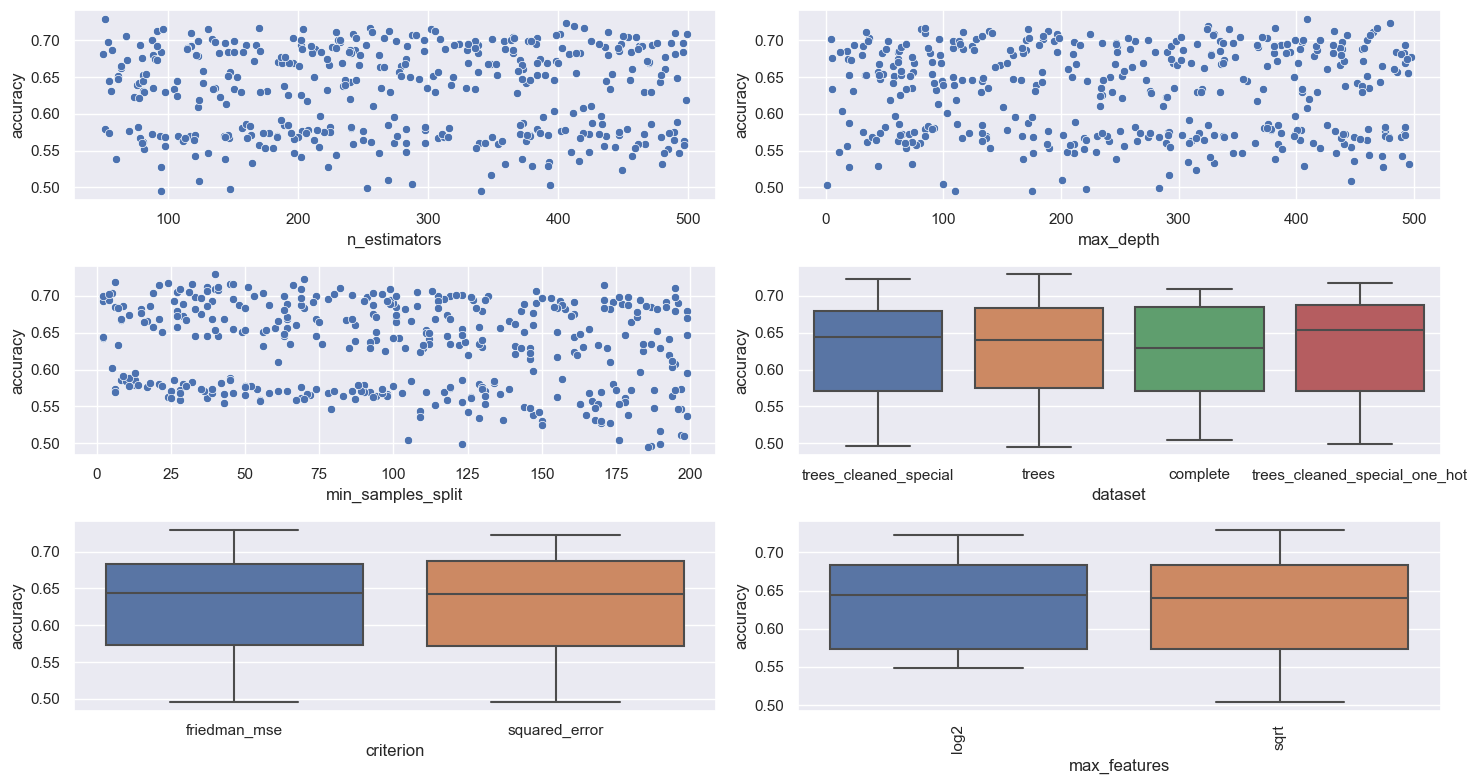

In [155]:
gradient_boosting = collection.find({"model": "gradient_boosting"})
gradient_boosting_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"]} for doc in gradient_boosting])
gradient_boosting_df["n_estimators"]= gradient_boosting_df["n_estimators"].apply(float)
visualize_accuracy_vs_hyperparameter(gradient_boosting_df, ["n_estimators", "max_depth", "min_samples_split", "dataset", "criterion", "max_features"], fig_types=["", "", "", "boxplot", "boxplot", "boxplot"])

# AdaBoost

C:\Users\jurko\AppData\Local\Temp\ipykernel_27532\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


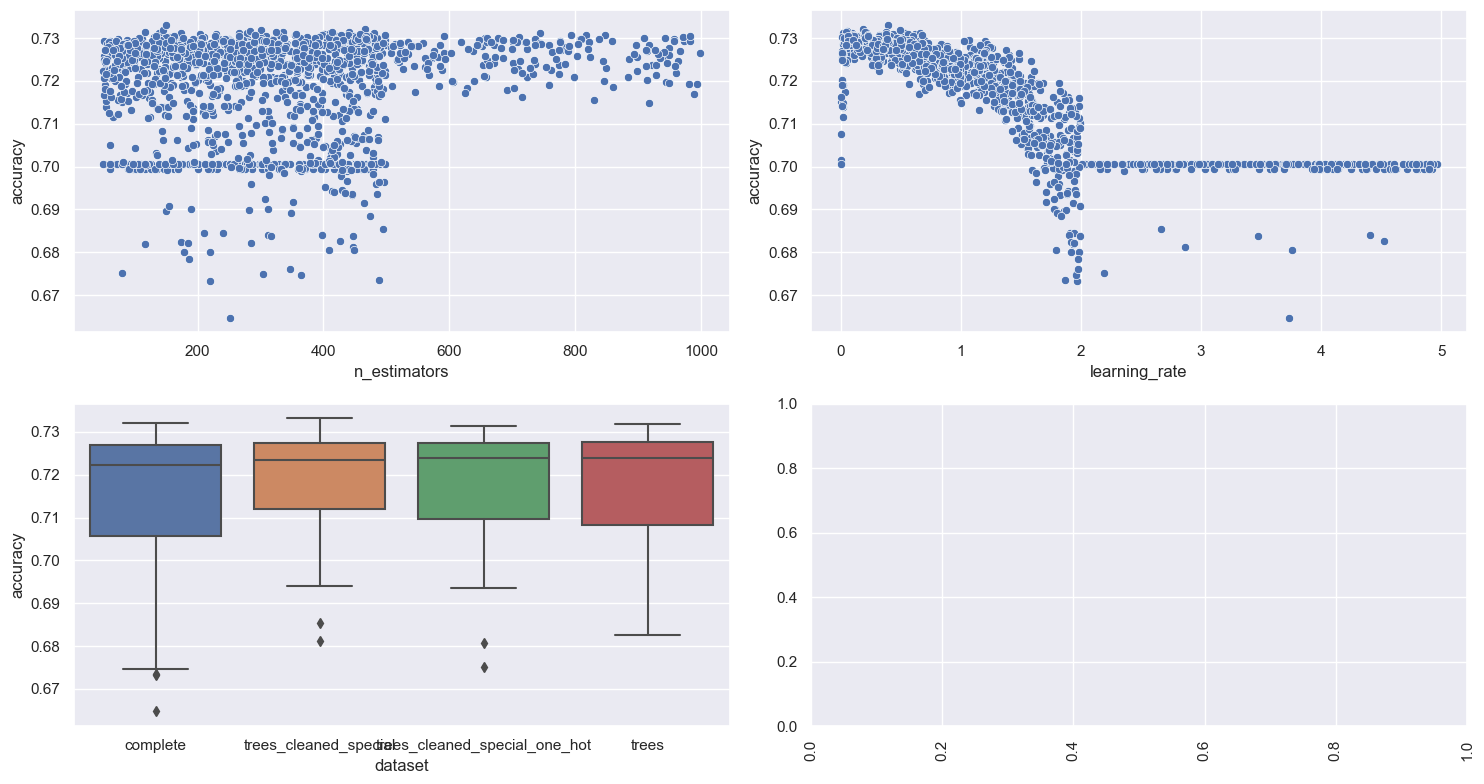

In [156]:

ada_boost = collection.find({"model": "ada_boost"})
ada_boost_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"]} for doc in ada_boost])
visualize_accuracy_vs_hyperparameter(ada_boost_df[ada_boost_df["accuracy"] > 0.65], ["n_estimators", "learning_rate", "dataset"], fig_types = ["", "", "boxplot"])


<Axes: xlabel='n_estimators', ylabel='learning_rate'>

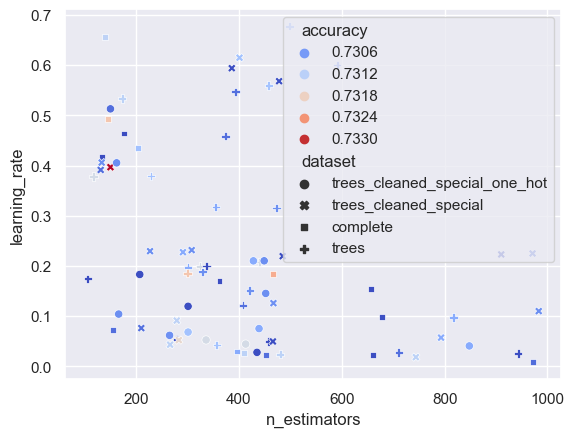

In [160]:
sns.scatterplot(ada_boost_df[ada_boost_df["accuracy"] > 0.730], x = "n_estimators", y = "learning_rate", style = "dataset", hue = "accuracy", palette="coolwarm")
# plt.yscale('log')

# XGBoost


C:\Users\jurko\AppData\Local\Temp\ipykernel_27532\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


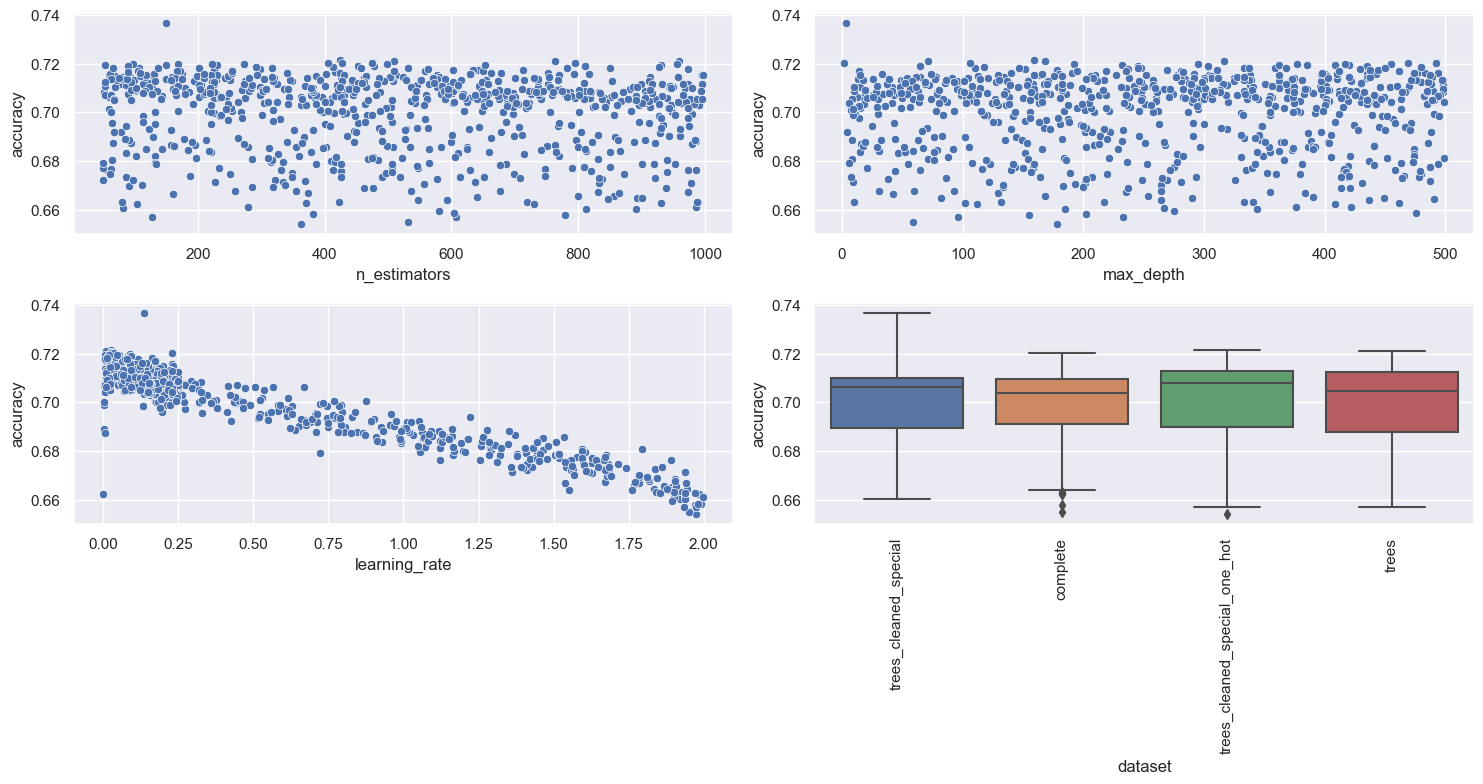

In [161]:
xgboost = collection.find({"model": "xgboost"})
xgboost_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"]} for doc in xgboost])
visualize_accuracy_vs_hyperparameter(xgboost_df[xgboost_df["accuracy"] > 0.65], ["n_estimators", "max_depth", "learning_rate", "dataset"], fig_types = ["", "", "", "boxplot"])

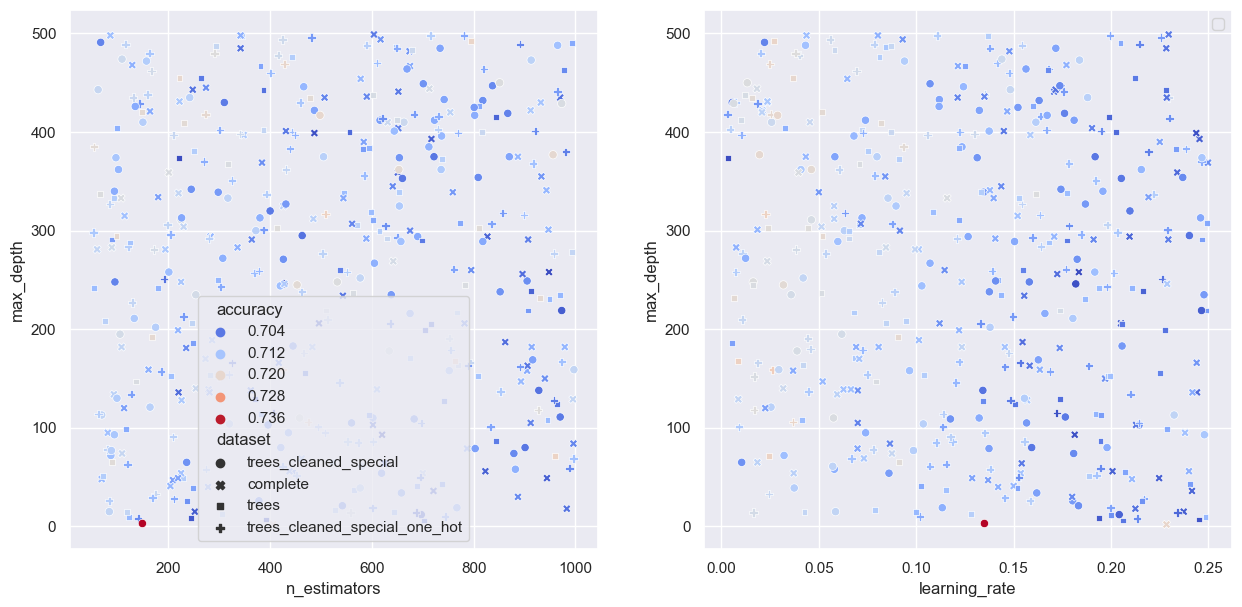

In [129]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,7))
sns.scatterplot(xgboost_df[(xgboost_df["learning_rate"] < 0.25) & (xgboost_df["accuracy"] > 0.7)], x = "n_estimators", y = "max_depth", style = "dataset", hue = "accuracy", ax = ax1 , palette="coolwarm")
sns.scatterplot(xgboost_df[(xgboost_df["learning_rate"] < 0.25) & (xgboost_df["accuracy"] > 0.7)], x = "learning_rate", y = "max_depth", style = "dataset", hue = "accuracy", ax = ax2 , palette="coolwarm")
plt.legend([])

# MLP

In [41]:
mlp_df.sort_values("accuracy", ascending = False)

,accuracy,dataset,hidden,activation_function,epochs,batch_size,device,lr,l2_lambda,n_layers
7,0.735548,complete,4,relu,840,128,cuda,0.057569,0.003164,1.0
15,0.734598,complete,4,tanh,635,64,cuda,0.010629,0.003415,1.0
24,0.734598,complete,2,tanh,590,128,cuda,0.061459,0.002936,1.0
96,0.734588,complete_pca,9,tanh,782,256,cuda,0.010337,0.000004,3.0
69,0.734364,complete_one_hot,5,relu,395,64,cuda,0.074512,0.007786,1.0
...,...,...,...,...,...,...,...,...,...,...
26,0.498267,complete,8,relu,672,64,cuda,0.062687,0.088742,1.0
58,0.496673,complete_one_hot,6,tanh,822,256,cuda,0.037327,0.095896,2.0
131,0.495709,complete_pca,5,relu,31,256,cuda,0.000566,0.023824,2.0
78,0.494411,complete,4,tanh,873,64,cuda,0.009059,0.091184,2.0


   accuracy   dataset  hidden activation_function  epochs  batch_size device  \
0  0.732202  complete       5                relu     812         128   cuda   
1  0.695823  complete       8                relu     759         256   cuda   
2  0.513689  complete       1                relu     764         128   cuda   
3  0.727858  complete       5                tanh     821          64   cuda   
4  0.727858  complete       6                relu     142         128   cuda   

         lr  l2_lambda  n_layers  
0  0.062625   0.022280       1.0  
1  0.063237   0.076969       1.0  
2  0.048116   0.077607       1.0  
3  0.049508   0.077925       1.0  
4  0.041824   0.051710       1.0  


C:\Users\jurko\AppData\Local\Temp\ipykernel_37128\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


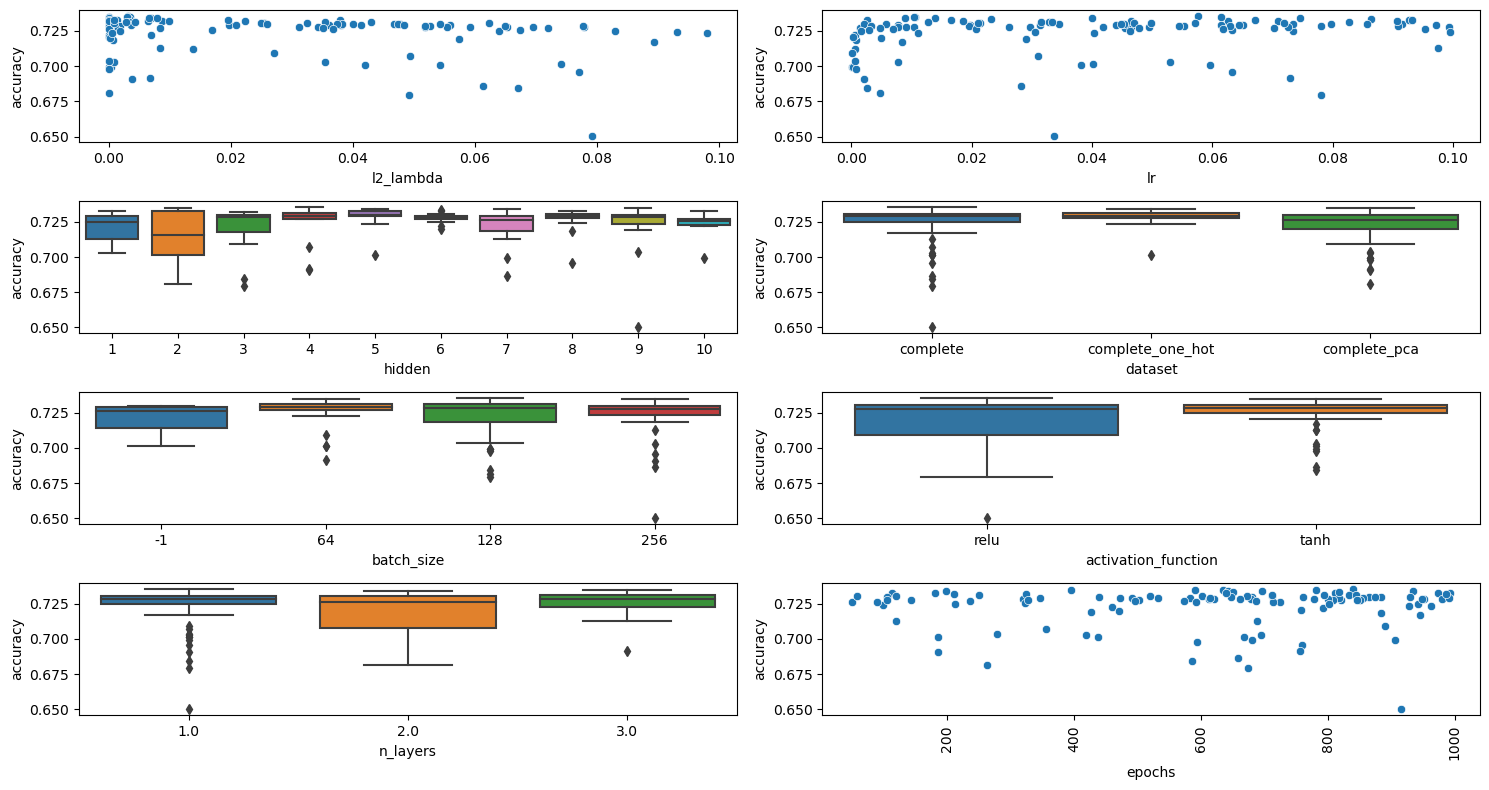

In [40]:

mlp = collection.find({"model": "mlp"})
mlp_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"], **doc["params_of_fit"]} for doc in mlp])
mlp_df["n_layers"] = mlp_df["n_layers"].fillna(1)
print(mlp_df.head())
visualize_accuracy_vs_hyperparameter(mlp_df[mlp_df["accuracy"] > 0.65], ["l2_lambda", "lr", "hidden", "dataset", "batch_size", "activation_function", "n_layers", "epochs"], fig_types = ["", "", "boxplot", "boxplot", "boxplot", "boxplot", "boxplot", ""])

<Axes: xlabel='l2_lambda', ylabel='lr'>

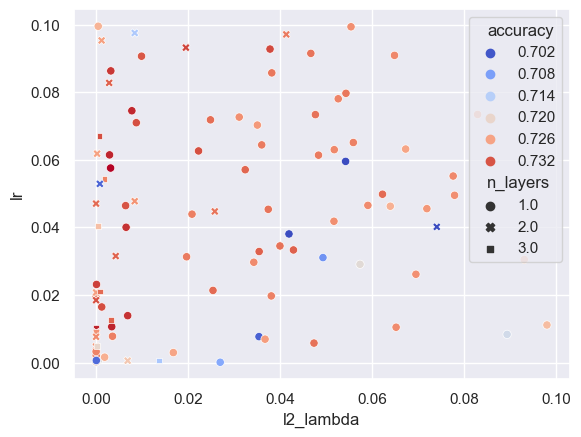

In [164]:
sns.scatterplot(mlp_df[mlp_df["accuracy"] > 0.7], x = "l2_lambda", y = "lr", style = "n_layers", hue = "accuracy", palette="coolwarm")

# Neighbor NN

   accuracy   dataset  n_neighbors  hidden activation_function  epochs  \
0  0.727362  complete          107       2                tanh     657   
1  0.725930  complete           88       3                relu     905   
2  0.685734  complete           98       9                relu     779   
3  0.727620  complete           92       5                tanh     598   
4  0.723032  complete           28       3                relu     191   

   batch_size device        lr  l2_lambda  n_layers  
0         256   cuda  0.043836   0.072647       1.0  
1         256   cuda  0.098056   0.057845       1.0  
2          64   cuda  0.039924   0.053995       1.0  
3          -1   cuda  0.031021   0.083135       1.0  
4         128   cuda  0.064119   0.088218       1.0  


C:\Users\jurko\AppData\Local\Temp\ipykernel_12372\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


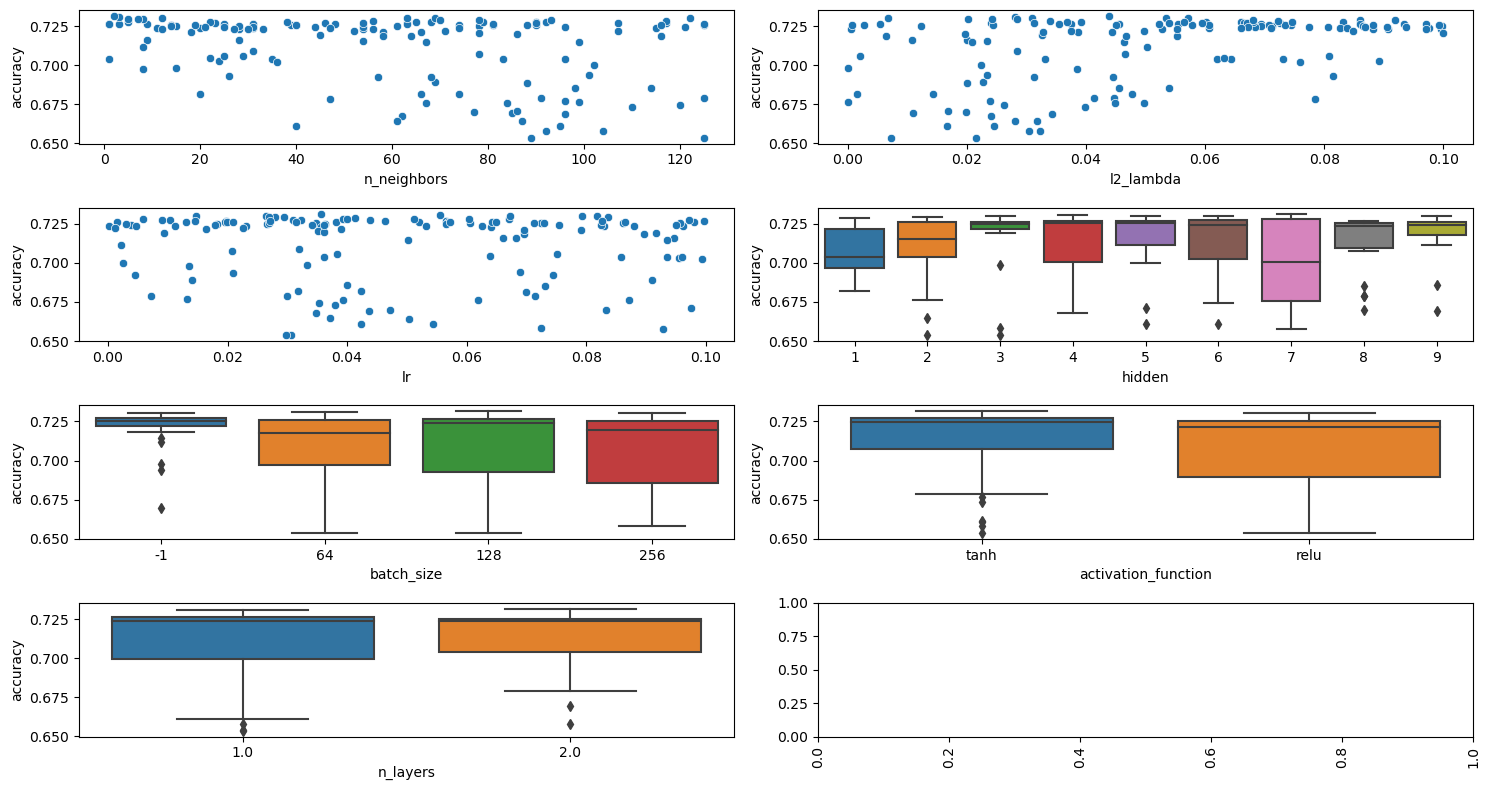

In [5]:
neighbor_nn = collection.find({"model": "neighbor_nn"})
neighbor_nn_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"], **doc["params_of_fit"]} for doc in neighbor_nn])
neighbor_nn_df["n_layers"] = neighbor_nn_df["n_layers"].fillna(1)
print(neighbor_nn_df.head())
visualize_accuracy_vs_hyperparameter(neighbor_nn_df[neighbor_nn_df["accuracy"] > 0.65], ["n_neighbors", "l2_lambda", "lr", "hidden", "batch_size", "activation_function", "n_layers"], fig_types = ["", "", "", "boxplot", "boxplot", "boxplot", "boxplot"])

<Axes: xlabel='l2_lambda', ylabel='lr'>

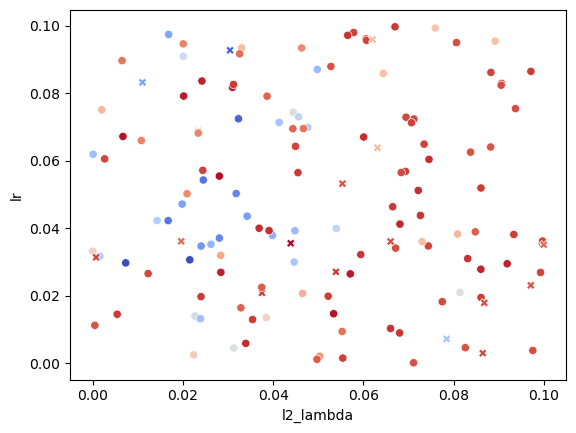

In [6]:
sns.scatterplot(neighbor_nn_df[neighbor_nn_df["accuracy"] > 0.65], x = "l2_lambda", y = "lr", style = "n_layers", hue = "accuracy" , palette="coolwarm", legend=False)

# Neighbor Compressed NN

   accuracy   dataset  n_neighbors  compression_size  hidden  \
0  0.725207  complete           62                49       9   
1  0.727620  complete           27               120       5   
2  0.714161  complete          102                82       2   
3  0.727851  complete           74               110       1   
4  0.723531  complete           35                28       4   

  activation_function  epochs  batch_size device        lr  l2_lambda  \
0                tanh     482          64   cuda  0.080723   0.064873   
1                tanh     549          64   cuda  0.032285   0.065786   
2                tanh     393          64   cuda  0.016783   0.007066   
3                relu     753         256   cuda  0.082413   0.029452   
4                relu     903          64   cuda  0.054258   0.079038   

   n_layers  
0       1.0  
1       1.0  
2       1.0  
3       1.0  
4       1.0  


C:\Users\jurko\AppData\Local\Temp\ipykernel_12372\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


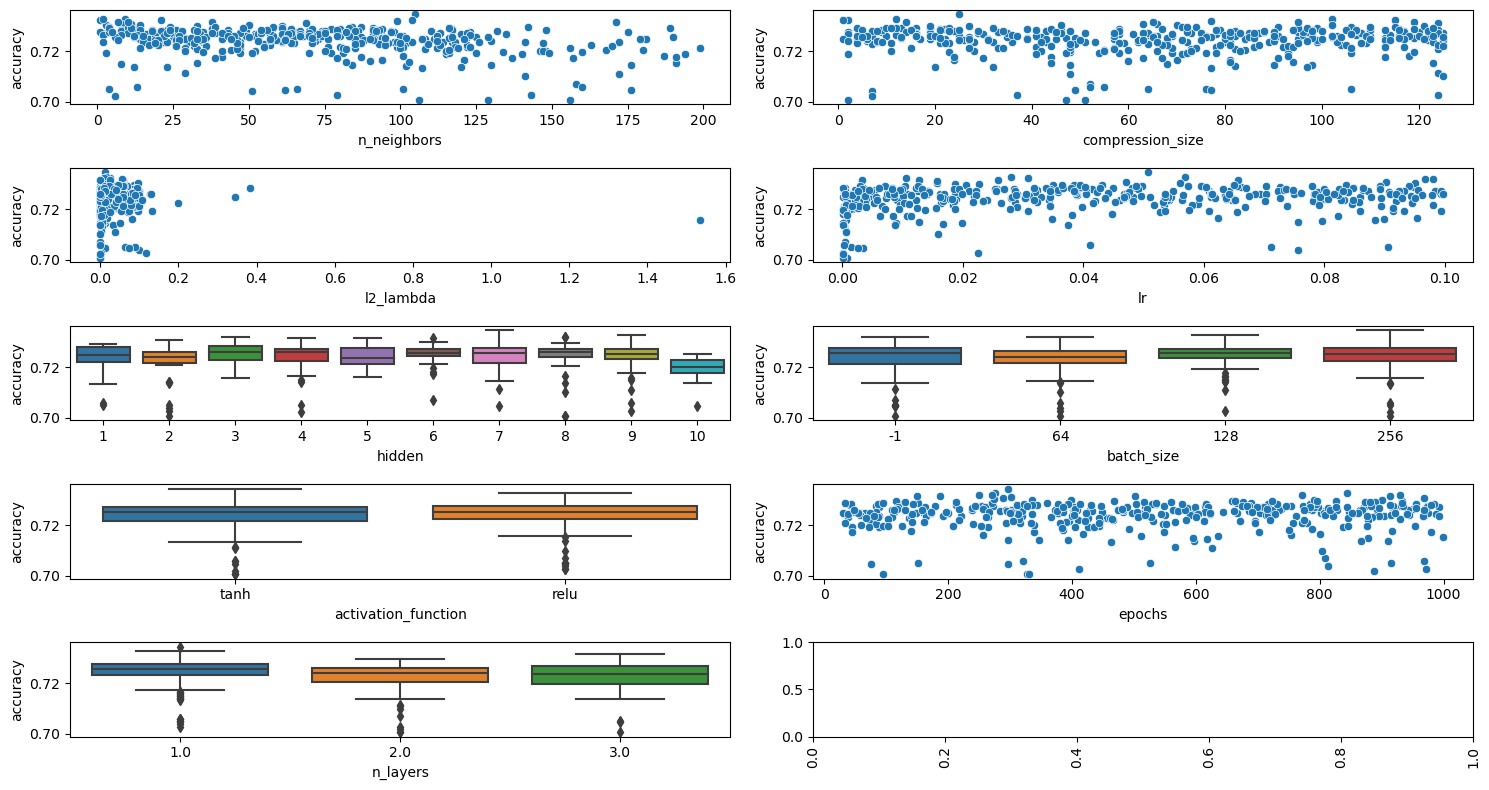

In [7]:
neighbor_compressed_nn = collection.find({"model": "neighbor_compressed_nn"})
neighbor_compressed_nn_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"], **doc["params_of_fit"]} for doc in neighbor_compressed_nn])
neighbor_compressed_nn_df["n_layers"] = neighbor_compressed_nn_df["n_layers"].fillna(1)
print(neighbor_compressed_nn_df.head())
visualize_accuracy_vs_hyperparameter(neighbor_compressed_nn_df[neighbor_compressed_nn_df["accuracy"] > 0.70], ["n_neighbors", "compression_size", "l2_lambda", "lr", "hidden", "batch_size", "activation_function", "epochs" ,"n_layers" ], fig_types = ["", "", "", "", "boxplot", "boxplot", "boxplot", "", "boxplot"])

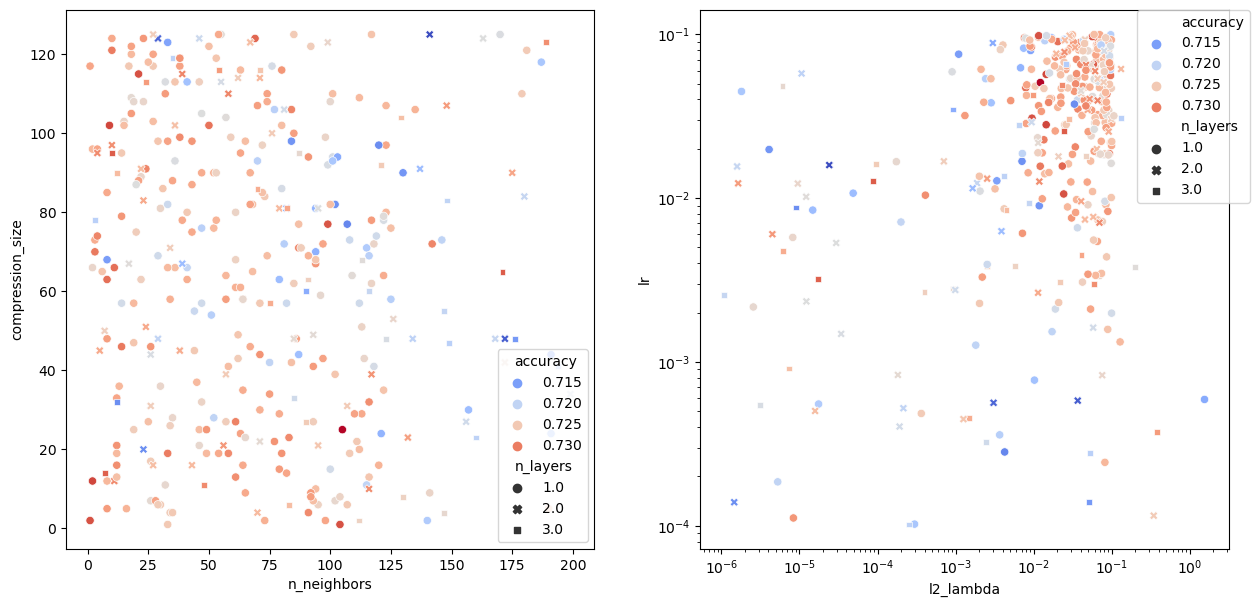

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,7))
sns.scatterplot(neighbor_compressed_nn_df[neighbor_compressed_nn_df["accuracy"] > 0.71], x = "n_neighbors", y = "compression_size", style = "n_layers", hue = "accuracy" , palette="coolwarm", ax = ax1)
sns.scatterplot(neighbor_compressed_nn_df[neighbor_compressed_nn_df["accuracy"] > 0.71], x = "l2_lambda", y = "lr", style = "n_layers", hue = "accuracy" , palette="coolwarm", ax = ax2)
ax2.set_xscale("log")
ax2.set_yscale("log")
plt.legend(bbox_to_anchor=(1.04 , 1), borderaxespad=0)

# Deep Neighbor Compressed

   accuracy   dataset  n_neighbors  compression_size  neighbor_size  hidden  \
0  0.580167  complete            2                62             13       5   
1  0.725700  complete          147                30              8       6   
2  0.498749  complete          151               109             10       1   
3  0.505348  complete          137                55              9       3   
4  0.502845  complete           36                16             12       5   

  activation_function  n_layers  epochs  batch_size device        lr  \
0                tanh         1     129          -1   cuda  0.002394   
1                tanh         1     813          64   cuda  0.000864   
2                tanh         2     161          -1   cuda  0.026491   
3                tanh         1     713         128   cuda  0.023489   
4                tanh         1      56         128   cuda  0.020447   

   l2_lambda  
0   0.195630  
1   0.045415  
2   0.356021  
3   0.142015  
4   0.878325  


C:\Users\jurko\AppData\Local\Temp\ipykernel_12372\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


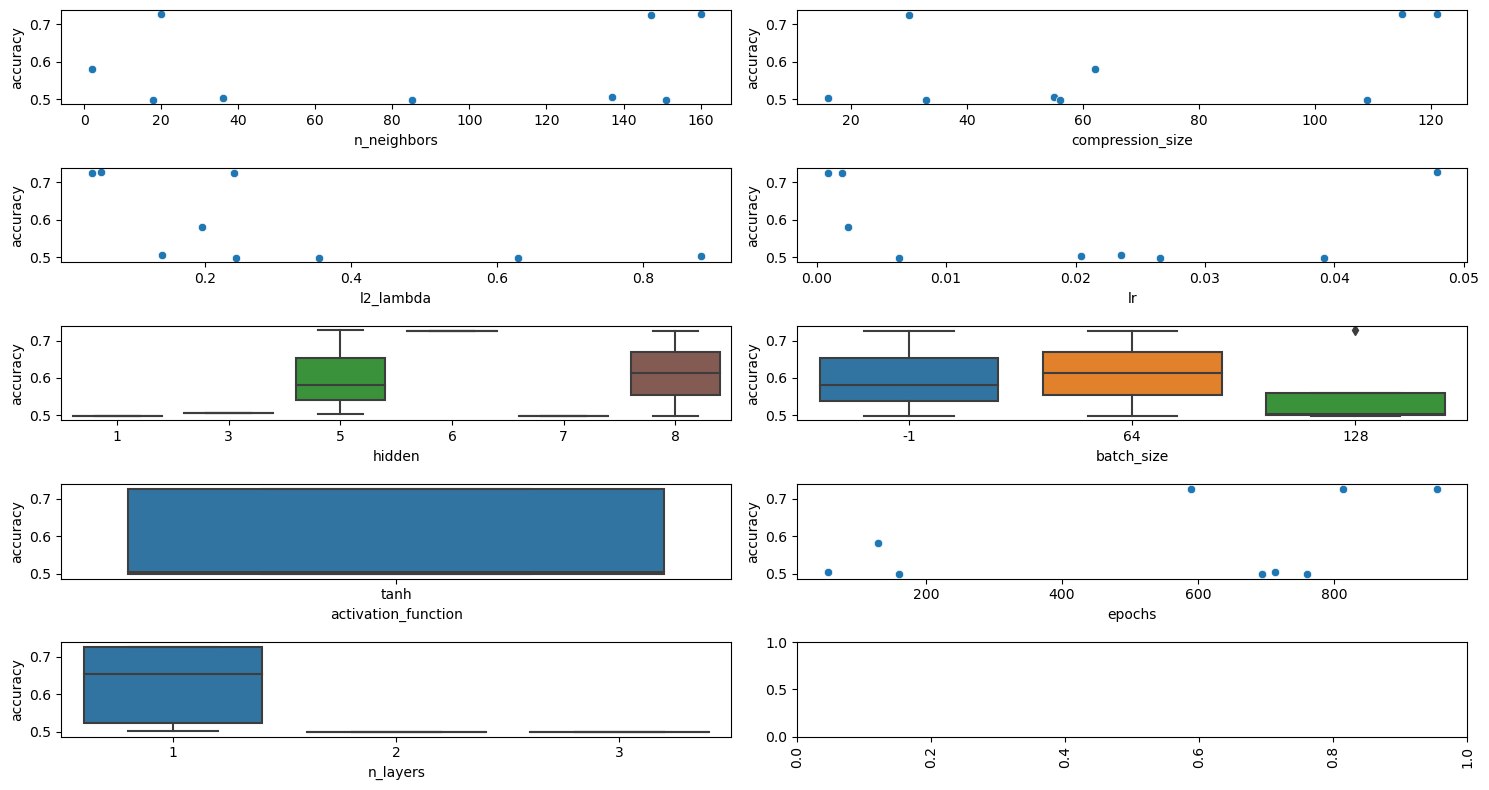

In [9]:
deep_neighbor_compressed_nn = collection.find({"model": "deep_neighbor_compressed_nn"})
deep_neighbor_compressed_nn_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_initialization"], **doc["params_of_fit"]} for doc in deep_neighbor_compressed_nn])
deep_neighbor_compressed_nn_df["n_layers"] = deep_neighbor_compressed_nn_df["n_layers"].fillna(1)
print(deep_neighbor_compressed_nn_df.head())
visualize_accuracy_vs_hyperparameter(deep_neighbor_compressed_nn_df[deep_neighbor_compressed_nn_df["accuracy"] > 0], ["n_neighbors", "compression_size", "l2_lambda", "lr", "hidden", "batch_size", "activation_function", "epochs" ,"n_layers" ], fig_types = ["", "", "", "", "boxplot", "boxplot", "boxplot", "", "boxplot"])

# Naive Bayes

In [28]:
naive_bayes = collection.find({"model": "naive_bayes"})
naive_bayes_df = pd.DataFrame([{"accuracy": doc["accuracy"], "dataset": doc["dataset"], **doc["params_of_fit"]} for doc in naive_bayes])

In [29]:
naive_bayes_df

,accuracy,dataset,alpha,anderson_statistic_threshold,use_bins
0,0.716540,naive_bayes,103,20.973165,False
1,0.712230,naive_bayes,455,5.764103,True
2,0.713434,naive_bayes,481,17.547184,True
3,0.716794,naive_bayes,289,23.373521,False
4,0.722323,naive_bayes,65,17.887083,True
...,...,...,...,...,...
595,0.716780,complete_pca,309,19.937287,False
596,0.716780,complete_pca,352,21.263809,False
597,0.716780,complete_pca,93,7.680526,False
598,0.716780,complete_pca,262,10.429492,False


C:\Users\jurko\AppData\Local\Temp\ipykernel_37128\1368099261.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


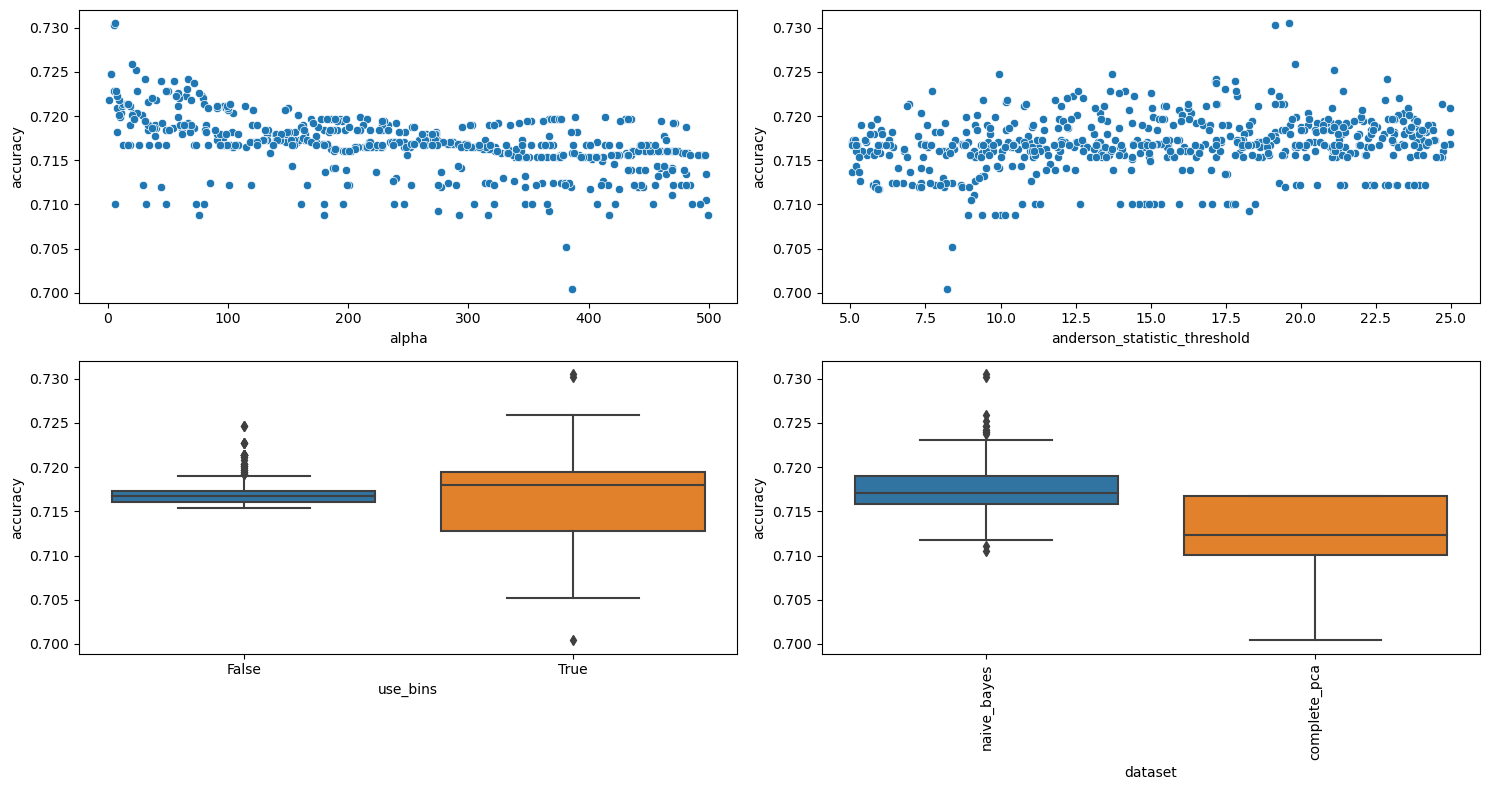

In [39]:
visualize_accuracy_vs_hyperparameter(naive_bayes_df[naive_bayes_df["accuracy"] > 0.70], ["alpha", "anderson_statistic_threshold", "use_bins", "dataset"], fig_types = ["", "","boxplot", "boxplot"])

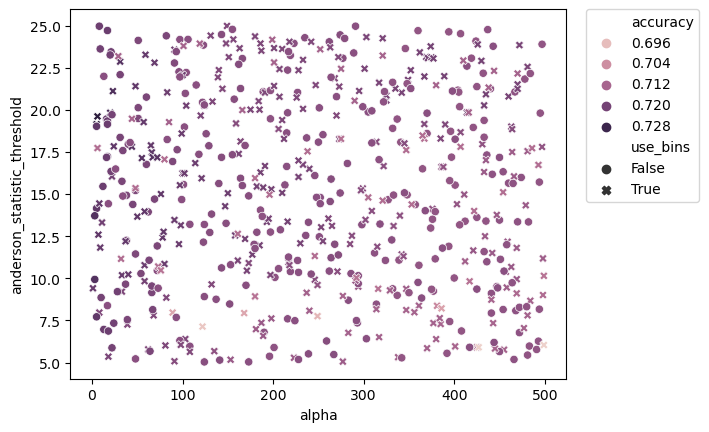

In [31]:
sns.scatterplot(naive_bayes_df, x = "alpha", y = "anderson_statistic_threshold", style = "use_bins", hue = "accuracy")
plt.legend(bbox_to_anchor=(1.04 , 1), borderaxespad=0)